In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow
import random
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import warnings
from keras import backend as K
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.models import load_model

In [ ]:
def load_images_from_folder(folder):
	images = []
	dirs = os.listdir(folder)

	for filename in dirs:
		if os.path.isfile(folder+filename):
			im = Image.open(folder+filename)
			imResize = im.resize((224,224), Image.ANTIALIAS)
			imResize = np.array(imResize)
			if imResize is not None:
				images.append(imResize)
	return images


def prepareData(parentPath):

	# Make a list of all the 0 label and 1 label images for train, val, and test sets

	all0_path = list()


	all1_path = list()


	all0_path.append(parentPath+'/Abnormal(Ulcer)/')
	all1_path.append(parentPath+'/Normal(Healthy skin)/')


	# Read images into respective lists


	allX = list()
	allY = list()
	xTrain = list()
	yTrain = list()
	xVal = list()
	yVal = list()
	xTest = list()
	yTest = list()

	# Prepare all data for 0 class
	print('\n\n Class Abnormal(Ulcer), reading started..\n\n')


	tempImgs = list()
	tempImgs = load_images_from_folder(all0_path[0])
	for i in range(len(tempImgs)):
		allX.append(tempImgs[i])
		allY.append(0)

	# Prepare all data for 1 class
	print('\n\n Class Normal(Healthy skin), reading started..\n\n')
	tempImgs = list()
	tempImgs = load_images_from_folder(all1_path[0])
	for i in range(len(tempImgs)):
		allX.append(tempImgs[i])
		allY.append(1)

	xTrain,xTest,yTrain,yTest = train_test_split(allX,allY, test_size=0.20, random_state=10, shuffle = True)

	xpTrain,xVal,ypTrain,yVal = train_test_split(xTrain,yTrain, test_size=0.10, random_state=10, shuffle = True)

	return xpTrain, ypTrain, xVal, yVal, xTest, yTest

### Mobile Net

In [ ]:
from keras.applications.mobilenet import MobileNet
def MobileNet_transfer_actual(input_shape):
  res = MobileNet(weights=None, include_top=False, input_shape=input_shape)
  for layer in res.layers:
    layer.trainable = True

  model = Sequential()
  model.add(res)

  model.add(Flatten())

  model.add(Dense(units=1024, activation='relu'))
  model.add(Dense(units=1, activation='sigmoid'))

  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

#### VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
def VGG16_transfer_actual(input_shape):
  res = VGG16(weights=None, include_top=False, input_shape=input_shape)
  for layer in res.layers:
    layer.trainable = True

  model = Sequential()
  model.add(res)

  model.add(Flatten())

  model.add(Dense(units=4096, activation='relu'))
  model.add(Dense(units=4096, activation='relu'))
  model.add(Dense(units=1, activation='sigmoid'))

  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
  return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

Importing dataset from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
parentPath='/content/drive/MyDrive/DFU/Patches'
xTrain, yTrain, xVal, yVal, xTest, yTest = prepareData(parentPath)

Mounted at /content/drive


 Class Abnormal(Ulcer), reading started..




 Class Normal(Healthy skin), reading started..




In [ ]:
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
xVal = np.array(xVal)
yVal = np.array(yVal)
xTest = np.array(xTest)
yTest = np.array(yTest)

# Prepare the data
img_width, img_height = 224, 224

if K.image_data_format() == 'channels_first':
  input_shape = (3, img_width, img_height)
else:
  input_shape = (img_width, img_height, 3)

# normalize inputs from 0-255 to 0-1
xTrain = xTrain / 255
xVal = xVal / 255
xTest = xTest / 255


Checking shape of Training, Validation and Test data

In [ ]:
print(xTrain.shape)
print(xVal.shape)
print(xTest.shape)

(759, 224, 224, 3)
(85, 224, 224, 3)
(211, 224, 224, 3)


In [ ]:
testPreds2 , testPreds3 = 0 , 0

Training Model

In [ ]:
model1 = MobileNet_transfer_actual(input_shape)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=200, restore_best_weights=True)
model1.fit(xTrain, yTrain, epochs=1000, batch_size=50, validation_data=(xVal, yVal), verbose=1, callbacks = [es])
testPreds2 = model1.predict(xTest)
print("MobileNet done.")

model1 = VGG16_transfer_actual(input_shape)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=200, restore_best_weights=True)
model1.fit(xTrain, yTrain, epochs=1000, batch_size=50, validation_data=(xVal, yVal), verbose=1, callbacks = [es])
testPreds3 = model1.predict(xTest)
print("VGG16 done.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 54,611,137
Trainable params: 54,589,249
Non-trainable params: 21,888
_________________________________________________________________


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/1000
16/16 [==============================] - 17s 334ms/step - loss: 0.4684 - accuracy: 0.7760 - val_loss: 0.7006 - val_accuracy: 0.5176
Epoch 2/1000
16/16 [==============================] - 3s 215ms/step - loss: 0.4352 - accuracy: 0.8472 - val_loss: 0.7347 - val_accuracy: 0.5176
Epoch 3/1000
16/16 [==============================] - 3s 197ms/step - loss: 0.2677 - accuracy: 0.8946 - val_loss: 0.8408 - val_accuracy: 0.5176
Epoch 4/1000
16/16 [==============================] - 3s 196ms/step - loss: 0.1847 - accuracy: 0.9289 - val_loss: 0.9522 - val_accuracy: 0.5176
Epoch 5/1000
16/16 [==============================] - 3s 194ms/step - loss: 0.1383 - accuracy: 0.9460 - val_loss: 1.0451 - val_accuracy: 0.5176
Epoch 6/1000
16/16 [==============================] - 3s 192ms/step - loss: 0.1131 - accuracy: 0.9552 - val_loss: 1.2166 - val_accuracy: 0.5176
Epoch 7/1000
16/16 [==============================] - 3s 195ms/step - loss: 0.1275 - accuracy: 0.9552 - val_loss: 1.5011 - val_accuracy

Calculation of Accuracy, Sensitivity, Specificity, Precision, Recall and AUC Value

In [ ]:
# print(testPreds2)
tp2 = []
for i in testPreds2:
  if i < 0.5:
    tp2.append(0)
  else:
    tp2.append(1)

# print(testPreds3)
tp3 = []
for i in testPreds3:
  if i < 0.5:
    tp3.append(0)
  else:
    tp3.append(1)




cm = confusion_matrix(yTest, tp2)
sensitivity2 = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity2 = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision2 = cm[0, 0] / (cm[0, 0] + cm[1, 0])
recall2 = cm[1, 1] / (cm[0, 1] + cm[1, 1])
accuracy2 = (cm[0,0] + cm[1,1]) / (cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
print("\n\nFor MobileNet")
print("\n Accuracy: ",accuracy2)
print()
print("\n Sensitivity: ",sensitivity2)
print()
print("\n Specificity: ",specificity2)
print()
print("\n Precision: ",precision2)
print()
print("\n Recall: ",recall2)
print()
print("AUC Value: ", roc_auc_score(yTest, tp2))




cm = confusion_matrix(yTest, tp3)
sensitivity3 = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity3 = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision3 = cm[0, 0] / (cm[0, 0] + cm[1, 0])
recall3 = cm[1, 1] / (cm[0, 1] + cm[1, 1])
accuracy3 = (cm[0,0] + cm[1,1]) / (cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
print("\n\nFor VGG16")
print("\n Accuracy: ",accuracy3)
print()
print("\n Sensitivity: ",sensitivity3)
print()
print("\n Specificity: ",specificity3)
print()
print("\n Precision: ",precision3)
print()
print("\n Recall: ",recall3)
print()
print("AUC Value: ", roc_auc_score(yTest, tp3))



For MobileNet

 Accuracy:  0.9620853080568721


 Sensitivity:  0.9680851063829787


 Specificity:  0.9572649572649573


 Precision:  0.9479166666666666


 Recall:  0.9739130434782609

AUC Value:  0.9626750318239681


For VGG16

 Accuracy:  0.966824644549763


 Sensitivity:  0.9468085106382979


 Specificity:  0.9829059829059829


 Precision:  0.978021978021978


 Recall:  0.9583333333333334

AUC Value:  0.9648572467721405


Confusion Matrix for MobileNet

<AxesSubplot:>

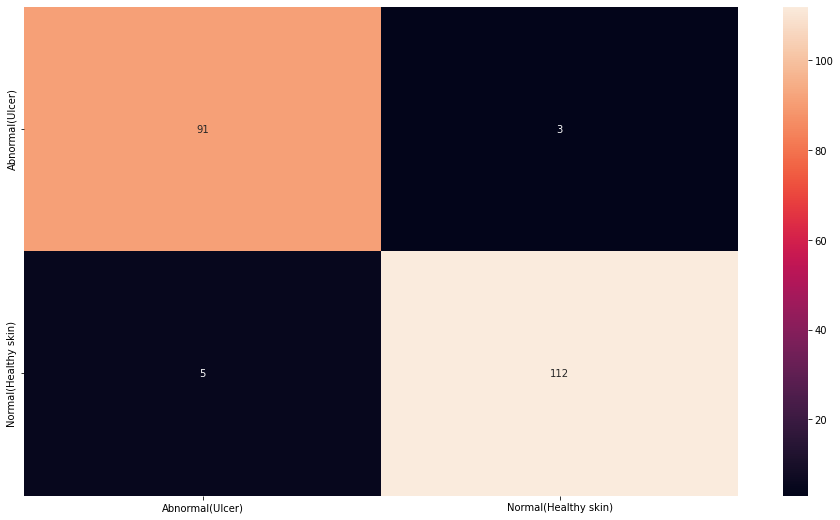

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
class_labels = ["Abnormal(Ulcer)","Normal(Healthy skin)"]
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(16,9))
y_pred_labels = [ np.argmax(label) for label in testPreds2]
cm = confusion_matrix(yTest, tp2)
sns.heatmap(cm, annot = True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

Confusion Matrix for VGG16

<AxesSubplot:>

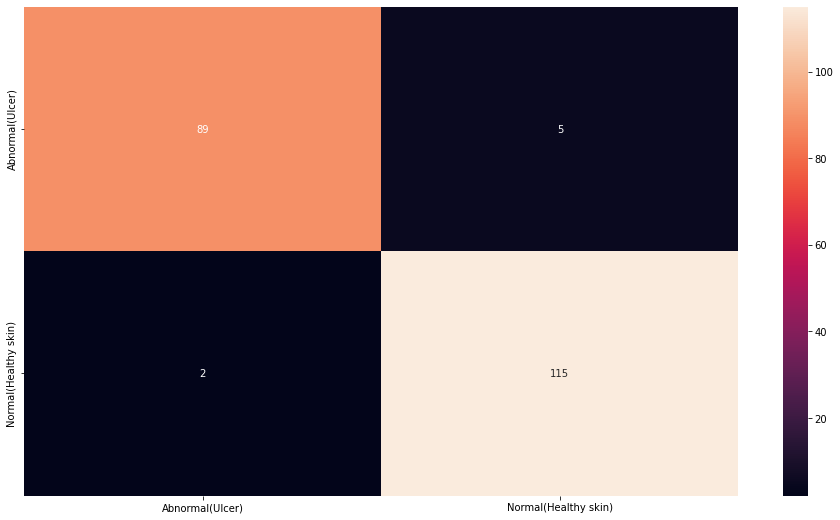

In [ ]:
plt.figure(figsize=(16,9))
y_pred_labels = [ np.argmax(label) for label in testPreds3]
cm = confusion_matrix(yTest, tp3)
sns.heatmap(cm, annot = True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

Calculate F1 Score

In [ ]:
from sklearn.metrics import f1_score

f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
# f1 = f1_score(yTest, testPreds1)
print(f1_score2)

f1_score3 = 2 * (precision3 * recall3) / (precision3 + recall3)
# f1 = f1_score(yTest, testPreds1)
print(f1_score3)


0.9607390300230947
0.9680775597067864


Classification Report

In [ ]:
from tabulate import tabulate
table = [['Model Name','Accuracy','Sensitivity','Specificity', 'Precision', 'Recall','F1 Score', 'AUC Value'],

         ['MobileNet', accuracy2, sensitivity2, specificity2, precision2, recall2,f1_score2, roc_auc_score(yTest, tp2)],
         ['VGG16',accuracy3, sensitivity3, specificity3, precision3, recall3,f1_score3, roc_auc_score(yTest, tp3)]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+--------------+------------+---------------+---------------+-------------+----------+------------+-------------+
| Model Name   |   Accuracy |   Sensitivity |   Specificity |   Precision |   Recall |   F1 Score |   AUC Value |
+==============+============+===============+===============+=============+==========+============+=============+
| MobileNet    |   0.962085 |      0.968085 |      0.957265 |    0.947917 | 0.973913 |   0.960739 |    0.962675 |
+--------------+------------+---------------+---------------+-------------+----------+------------+-------------+
| VGG16        |   0.966825 |      0.946809 |      0.982906 |    0.978022 | 0.958333 |   0.968078 |    0.964857 |
+--------------+------------+---------------+---------------+-------------+----------+------------+-------------+
